# Prediction of Mutation Effect: Minimizing the impact of randomization
# Predator


<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">PredatorStudy.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">August 27th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
    
    
- [x] Apply on Cancer Datasets
    > For now, a portion of all BRCA. But will be updated.
     
- [x] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
- [x] We use Predator object to conduct experiments.
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*


* Target (Cancer) data: 
    - *BRCA_INTERFACE_A2.txt*

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
from IPython.display import display
from tqdm.notebook import tqdm
from helpers.common import print_annotation, get_file_path
from helpers.displayers import display_label_counts, display_labels, visualize_label_counts
from helpers.visualizers import (
    visualize_sampled_train_datasets_label_counts
)

NUM_EXPERIMENT_REPEAT = 50

SEED = 42
random.seed(SEED)
random_seeds = random.sample(range(1, 99999), NUM_EXPERIMENT_REPEAT)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"
BRCA_PATH = "../data/BRCA_INTERFACE_A2.txt"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [2]:
from Predator import Predator

In [3]:
predator = Predator(project_common_file_dir=PROJECT_COMMON_FILE_DIR, 
                    mutations_path=MUTATIONS_PATH, 
                    tcga_code_path_pairs=[('brca', BRCA_PATH)],
                    initial_columns_path=INITIAL_COLUMNS_PATH, 
                    n_experiment=50)

2021-09-02 11:38:46 | DEBUG    | Predator | Initializing Predator ..
2021-09-02 11:38:46 | DEBUG    | helpers.data_materials | Initialize `train_data` ..
2021-09-02 11:38:46 | DEBUG    | helpers.data_materials | Initialize `train_data_processed` ..
2021-09-02 11:38:46 | DEBUG    | helpers.data_materials | Initialize `brca` ..
2021-09-02 11:38:46 | DEBUG    | helpers.data_materials | Initialize `target_brca_data` ..


## Datasets

### Original Datasets

#### 1. Training Data: Mutations

In [4]:
predator.data_materials["train_data"].head(3)

,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


#### 2. TCGA Cancer Datasets

##### BRCA

In [5]:
predator.data_materials["brca"].head(3)

,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


### Processed Datasets

#### 1. Preprocessed Training Data 

In [6]:
predator.data_materials["train_data_processed"].head(3)

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.21970,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.07695,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.69571,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435


,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


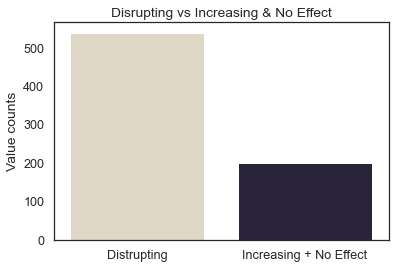

In [7]:
visualize_label_counts(predator.data_materials["train_data_processed"])
display_label_counts(predator.data_materials["train_data_processed"])

#### 2. Preprocessed TCGA Cancer Datasets

##### BRCA

In [8]:
predator.data_materials["target_brca_data"].head(3)

,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,R24H,Q9BY11,0.5343,0.530760,0.9857,0.936088,0.730056,0.957610,0.741488,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,R24H,Q9UNF0,0.5884,0.579682,0.9928,0.993160,0.795178,0.927519,0.019506,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,R24H,Q9UNF0-2,0.5884,0.579682,0.9928,0.993160,1.030540,0.927519,0.014609,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.300,2331.75,3.55240,4.79224


## Data Sampling with Unique Proteins

In [9]:
predator.sample_spsm()

2021-09-02 11:38:52 | DEBUG    | Predator | sampling ..


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'brca', 'target_brca_data', 'sampled_train_data_list'])

In [11]:
predator.data_materials["sampled_train_data_list"][0].head()

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,T629D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,1.252190,0.403159,...,453.0,68.34290,68.21480,59.2629,59.2629,510.690,298.820,809.510,4.36339,4.34314
3,0,O43521-3,G66E,P10415-2,1.0000,0.714286,0.6505,0.435452,1.866070,-0.076393,...,181.0,2.15789,3.50531,30.7415,30.7626,421.875,272.215,694.090,3.41921,1.76365
4,1,Q13418,Q362H,Q9NVD7,0.9925,0.971054,1.0000,0.961240,0.621791,0.206189,...,391.0,60.07690,60.06430,33.8017,33.8017,406.135,174.195,580.330,3.39874,3.39874


In [12]:
# Number of sampled train data
len(predator.data_materials["sampled_train_data_list"])

50

### Label Distributions in Training Data

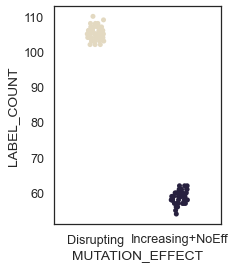

In [13]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='strip')

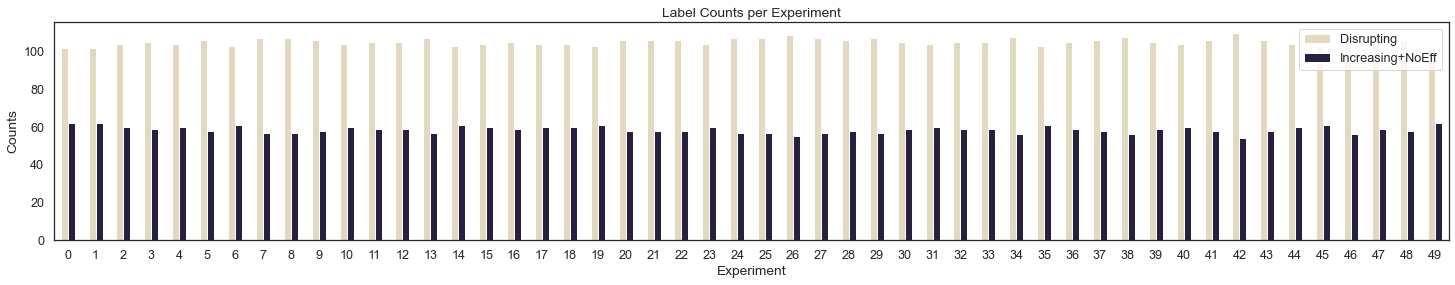

In [14]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='bar')

## Preparing the Train Data Materials for Machine Learning Algorithms

In [15]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'brca', 'target_brca_data', 'sampled_train_data_list'])

In [16]:
predator.data_materials.prepare_model_data_materials()  # it will initialize Xs etc. too

2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | preparing datasets for ML ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Initializing model datasets ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_materials | Appending data materials ..
2021-09-02 11:39:07 | DEBUG    | helpers.data_material

In [17]:
print(len(predator.data_materials["Xs"]))
predator.data_materials["Xs"][0].head()

50


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,0.483871,0.9930,0.863124,5.977720,-0.103788,0.841449,1.551375,-0.805142,-8.790,...,316.0,8.64833,8.63232,90.3947,89.1921,524.985,258.980,783.96,2.46202,2.98422
1,1.0000,1.000000,0.4167,0.372027,1.700660,-0.116186,0.028181,-0.446740,0.127684,-7.998,...,249.0,27.72640,27.86500,139.5970,139.5970,386.025,245.065,631.09,3.57046,3.48332
2,0.6803,0.517968,0.4645,0.481888,0.937272,0.058100,0.165439,-0.028320,1.569780,-3.628,...,318.0,293.43500,294.70400,45.8003,45.8003,716.790,358.840,1075.62,4.33509,4.33509
3,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,-6.333,...,712.0,200.85600,199.44300,62.1484,62.1484,267.500,155.585,423.08,3.07379,3.07379
4,0.9032,0.902219,0.8519,0.838599,1.414480,0.156140,0.500075,1.100519,0.299283,-5.300,...,236.0,49.67150,48.43100,23.9715,23.9715,176.945,115.630,292.58,2.94553,5.48003


## Initial Insights

For each experiment, the models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [18]:
predator.run_evaluate_valid(models_type='default')

2021-09-02 11:39:08 | DEBUG    | helpers.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-09-02 11:39:08 | DEBUG    | helpers.evaluation | Evaluating with default models.


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6667
Balanced accuracy score : 0.5952
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6190
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6548
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6012
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Accuracy score		: 0.7273
Balanced accuracy score : 0.6429
-------- EXPERIMENT:  6 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.sh

In [19]:
from helpers.visualizers import visualize_accuracy_metrics

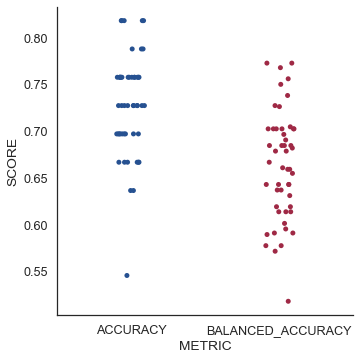

In [20]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["initial_scoring"]["acc_scores"], 
    predator.eval_valid.scores["initial_scoring"]["balan_acc_scores"],
    kind='strip'
)

## SHAP Feature Importance Ranking

In [21]:
# shap_top_ns = [10, 20]
shap_top_ns = [5, 10, 20, 30, 40]

In [22]:
predator.init_shap_feature_selector(shap_top_ns)

2021-09-02 11:39:25 | DEBUG    | helpers.feature_selection | Initializing ShapFeatureSelector ..


2021-09-02 11:39:25 | DEBUG    | helpers.feature_selection | Loading ShapFeatureSelector ..


  0%|          | 0/50 [00:00<?, ?it/s]

 === SELECTED FEATURES === 
 --- SHAP TOP 5 ---
Experiment 1
['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut', 'Final_ddG']

Experiment 2
['Provean_score', 'EL2_score', 'Final_ddG', 'solvation_polar_wt', 'entropy_mainchain_wt']

Experiment 3
['EL2_score', 'Final_ddG', 'Provean_score', 'Interface_contact_distance_mut', 'Interface_contact_distance_wt']

Experiment 4
['EL2_score', 'Provean_score', 'Final_ddG', 'Interface_contact_distance_mut', 'entropy_sidechain_mut']

Experiment 5
['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut', 'Solvent_accessibility_wt']

Experiment 6
['Final_ddG', 'EL2_score', 'Provean_score', 'solvation_polar_mut', 'solvation_polar_wt']

Experiment 7
['EL2_score', 'Provean_score', 'Final_ddG', 'Matrix_score', 'electrostatics_mut']

Experiment 8
['EL2_score', 'Provean_score', 'Final_ddG', 'Solvent_accessibility_mut', 'pcv_vdW_self_wt']

Experiment 9
['Provean_score', 'EL2_score', 'Final_ddG', 'Matrix_score', 'ProteinSolver_score']


## Aggregated Feature Selection

In [23]:
predator.aggregate_selected_features('occurrance')

2021-09-02 11:39:39 | DEBUG    | helpers.data_materials | Initialize feature selected data materials [n_top=5]..
2021-09-02 11:39:40 | DEBUG    | helpers.data_materials | Initialize feature selected data materials [n_top=10]..
2021-09-02 11:39:40 | DEBUG    | helpers.data_materials | Initialize feature selected data materials [n_top=20]..
2021-09-02 11:39:40 | DEBUG    | helpers.data_materials | Initialize feature selected data materials [n_top=30]..
2021-09-02 11:39:40 | DEBUG    | helpers.data_materials | Initialize feature selected data materials [n_top=40]..


In [24]:
predator.shap_feature_selector.aggregated_feature_selector.n_features_to_selected_features_occurrences_counts

defaultdict(dict,
            {5: defaultdict(int,
                         {'Provean_score': 49,
                          'EL2_score': 50,
                          'Matrix_score': 22,
                          'electrostatics_mut': 2,
                          'Final_ddG': 46,
                          'solvation_polar_wt': 4,
                          'entropy_mainchain_wt': 3,
                          'Interface_contact_distance_mut': 5,
                          'Interface_contact_distance_wt': 1,
                          'entropy_sidechain_mut': 1,
                          'sidechain_hbond_mut': 1,
                          'Solvent_accessibility_wt': 8,
                          'solvation_polar_mut': 3,
                          'Solvent_accessibility_mut': 9,
                          'pcv_vdW_self_wt': 1,
                          'ProteinSolver_score': 2,
                          'Interactor_alignment_score': 22,
                          'entropy_sidechain_wt': 3,
    

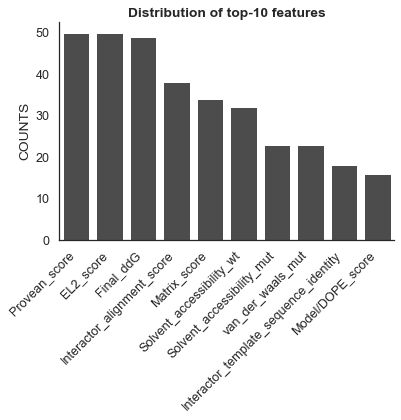

In [25]:
from helpers.visualizers import visualize_distribution_top_n_features

visualize_distribution_top_n_features(predator.shap_feature_selector, 10)

In [26]:
predator.shap_feature_selector.display_rankings(10, extract=True)

2021-09-02 11:39:41 | DEBUG    | helpers.feature_selection | Displaying rankings ..
2021-09-02 11:39:41 | DEBUG    | helpers.feature_selection | Extracting rankings ..
2021-09-02 11:39:41 | DEBUG    | helpers.feature_selection | Rankings are extracted to file rankings_10.csv.


,0,1,2,3,4,5,6,7,8,9
0,Provean_score,EL2_score,Matrix_score,electrostatics_mut,Final_ddG,Interactor_alignment_score,Solvent_accessibility_mut,Model/DOPE_score,van_der_waals_mut,pcv_vdW_self_wt
1,Provean_score,EL2_score,Final_ddG,solvation_polar_wt,entropy_mainchain_wt,sidechain_hbond_mut,Solvent_accessibility_mut,Solvent_accessibility_wt,van_der_waals_mut,Model/DOPE_score
2,EL2_score,Final_ddG,Provean_score,Interface_contact_distance_mut,Interface_contact_distance_wt,entropy_sidechain_wt,Solvent_accessibility_mut,entropy_sidechain_mut,pcv_vdW_wt,Interactor_alignment_score
3,EL2_score,Provean_score,Final_ddG,Interface_contact_distance_mut,entropy_sidechain_mut,Interactor_template_sequence_identity,van_der_waals_mut,Interface_contact_distance_wt,sidechain_hbond_wt,Model/DOPE_score
4,EL2_score,Provean_score,Final_ddG,sidechain_hbond_mut,Solvent_accessibility_wt,Matrix_score,entropy_sidechain_mut,entropy_sidechain_wt,sidechain_hbond_wt,Interactor_template_sequence_identity


In [27]:
predator.shap_feature_selector.n_features_to_aggregated_features

{5: ['EL2_score',
  'Provean_score',
  'Final_ddG',
  'Matrix_score',
  'Interactor_alignment_score'],
 10: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'van_der_waals_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score'],
 20: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score',
  'entropy_sidechain_mut',
  'electrostatics_mut',
  'ProteinSolver_score',
  'ProtBert_score',
  'solvation_polar_wt',
  'entropy_mainchain_wt',
  'solvation_polar_mut',
  'entropy_sidechain_wt',
  'pcv_vdW_self_wt',
  'Interface_contact_distance_mut'],
 30: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Solvent_accessibility_wt',

In [28]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

## Evaluation Metrics

In [29]:
from helpers.evaluation import evaluate_metrics

In [30]:
predator.initialize_evalutation_metrics()

2021-09-02 11:39:42 | INFO     | helpers.evaluation | Initializing EvaluationMetrics..
2021-09-02 11:39:42 | INFO     | helpers.evaluation | Initialize_benchmark_dataframes ..


In [31]:
predator.eval_metrics.run_eval_metrics(n_repeats=5, n_jobs=4, verbose=True)

2021-09-02 11:01:49 | INFO     | helpers.evaluation | Running evaluation metrics ..


  0%|          | 0/50 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
X_train_exp_0_provean       : 0.5025
X_train_exp_0_ddG           : 0.4524
X_train_exp_0               : 0.539
X_train_exp_0_shap_5        : 0.5262


KeyboardInterrupt: 

In [45]:
predator.eval_metrics.scoring_metrics_data

,Provean,$\Delta\Delta$G,All Columns,SHAP Columns (5),SHAP Columns (10),SHAP Columns (20),SHAP Columns (30),SHAP Columns (40)
METRIC,,,,,,,,
accuracy,0.613144,0.597714,0.713000,0.717376,0.733922,0.738922,0.720950,0.720630
balanced_accuracy,0.583620,0.559224,0.646888,0.663800,0.681016,0.686866,0.667066,0.659676
f1,0.449656,0.418598,0.486074,0.530802,0.550302,0.538476,0.526264,0.501310
f1_macro,0.568500,0.546706,0.642212,0.657532,0.680010,0.677192,0.665176,0.653016
f1_micro,0.610228,0.593574,0.718456,0.715364,0.730800,0.733556,0.718830,0.717604
precision,0.471266,0.440358,0.671626,0.639130,0.682772,0.715218,0.667878,0.653998
precision_macro,0.596286,0.563826,0.708532,0.695778,0.719388,0.729482,0.724526,0.717476
precision_micro,0.612060,0.596468,0.716294,0.713676,0.732400,0.734412,0.723658,0.718556
recall,0.489500,0.434100,0.418200,0.499600,0.500300,0.479900,0.467100,0.439100


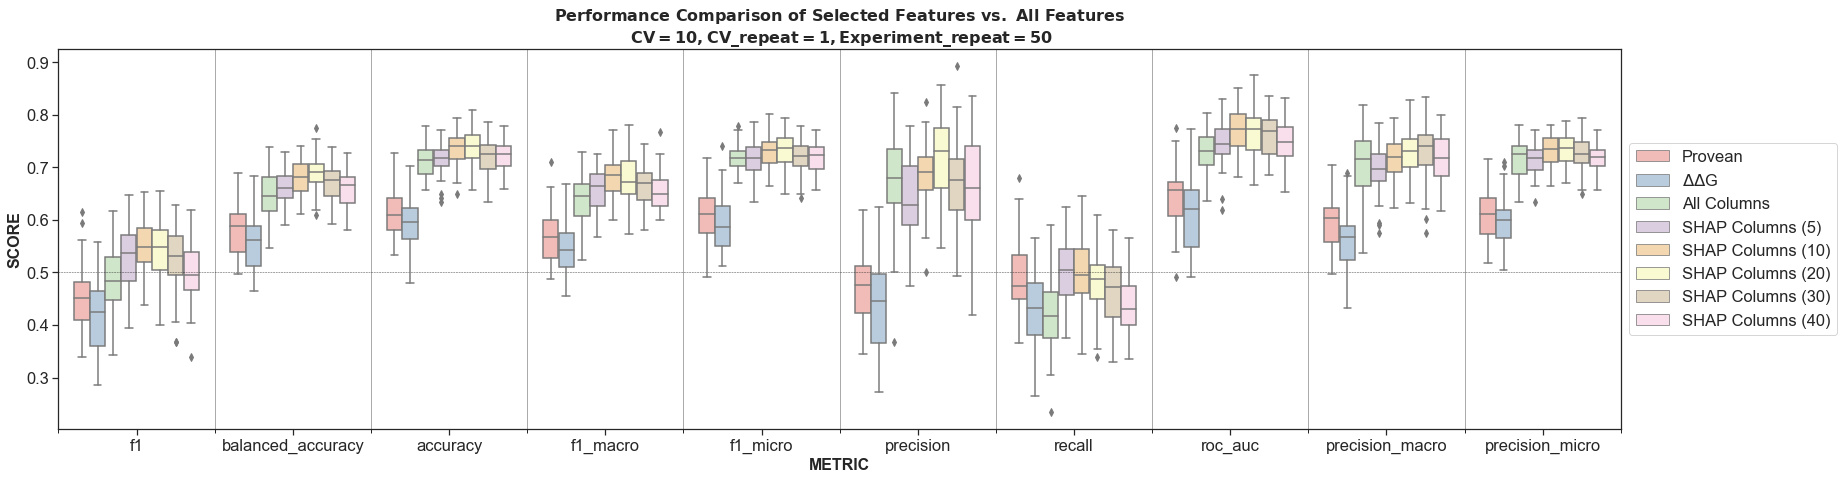

In [84]:
predator.eval_metrics.plot_performance_comparison_results()

## Fine Tuning

Fine Tuning on 80% of data (training *set*)

In [94]:
determined_feature_set = "shap_10"
predator.set_determined_feature_set(determined_feature_set)

2021-09-02 12:13:52 | DEBUG    | Predator | Setting determined feature set to `shap_10`.
2021-09-02 12:13:52 | DEBUG    | Predator | Setting determined features to 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score'].


In [95]:
predator.init_fine_tuner(
    n_iter=1,
    n_repeats_cv=1,
    n_jobs=4,
    verbose=0,
)

In [96]:
predator.run_search("randomized")

2021-09-02 12:13:52 | DEBUG    | helpers.fine_tuning | Running randomized search for each experiment ..
2021-09-02 12:13:52 | DEBUG    | helpers.fine_tuning | PARAM_GRID: {'max_depth': [2, 5, 10], 'n_estimators': [10, 25, 50, 75, 100, 200, 400], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt', None], 'class_weight': ['balanced', None]}


  0%|          | 0/50 [00:00<?, ?it/s]

In [97]:
predator.fine_tuner.classifiers_attributes_data.head()

,best_params_,best_estimator_,best_score_
EXP_1,"{'n_estimators': 50, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=2, min_sampl...",0.677083
EXP_2,"{'n_estimators': 10, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=5, max_featu...",0.665694
EXP_3,"{'n_estimators': 25, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.704028
EXP_4,"{'n_estimators': 75, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=10, min_samp...",0.631111
EXP_5,"{'n_estimators': 25, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.688472


In [98]:
predator.fine_tuner.best_estimators[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [99]:
len(predator.tuned_models)

50

In [100]:
predator.tuned_models[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', min_samples_split=5,
                        n_estimators=25, random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=None,
                        min_samples_split=5, n_estimators=75, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=10,
                        max_features='sqrt', n_estimators=25, random_state=5)]

In [101]:
predator.fine_tuner.best_estimators[:5] == predator.tuned_models[:5]

True

In [102]:
predator.default_models[0]

RandomForestClassifier(random_state=42)

In [103]:
len(predator.tuned_models)

50

In [104]:
predator.tuned_models[0]

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=None,
                       min_samples_split=5, n_estimators=50, random_state=1)

In [105]:
predator.tuned_models[1]

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=2)

## Performance of Tuned Models on Validation Data

For each experiment, the **hyper-tuned** models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [106]:
predator.run_evaluate_valid(models_type='tuned')

2021-09-02 12:15:03 | DEBUG    | helpers.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-09-02 12:15:03 | DEBUG    | helpers.evaluation | Evaluating with tuned models.
2021-09-02 12:15:03 | DEBUG    | helpers.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7024
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6726
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7202
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.8788
Balanced accuracy score : 0.8333
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Accuracy score		: 0.7879
Balanced accuracy score : 0.7262
-------- EXPERIMENT:  6 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.sh

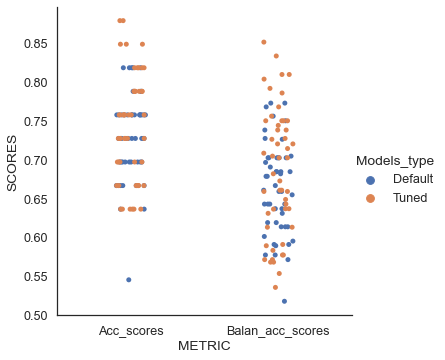

In [107]:
predator.eval_valid.comparison_default_vs_tuned(kind='strip')

In [108]:
predator.eval_valid.comparison_data

Models_type,Default,Tuned
Acc_scores,0.728485,0.740606
Balan_acc_scores,0.663214,0.683885


## Fit Finalized Models

For each experiment, the **hyper-tuned** models are fitted with all of training data. These models then will be used to make prediction on TCGA Cancer Datasets.

In [111]:
predator.fit_finalized_models()

2021-09-02 12:16:12 | DEBUG    | Predator | Fitting finalized models with all training data ..


  0%|          | 0/50 [00:00<?, ?it/s]

## Finalized Cross Validation

In [134]:
from helpers.machine_learning_utils import cross_val_confusion_matrix_via

In [141]:
from sklearn.metrics import confusion_matrix

In [142]:
confusion_matrix(predator.data_materials["ys"][0], pred_finalized_test)

array([[87, 15],
       [17, 45]], dtype=int64)

In [142]:
confusion_matrix(predator.data_materials["ys"][0], pred_finalized_test)

array([[87, 15],
       [17, 45]], dtype=int64)

  0%|          | 0/50 [00:00<?, ?it/s]

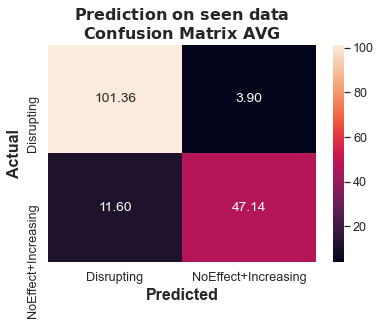

In [181]:
tns = []
fps = []
fns = []
tps = []

for exp in tqdm(range(predator.n_experiment)):
    pred_finalized_test = predator.finalized_models[exp].predict(
        predator.data_materials["Xs_shap_10"][exp]
    )
    tn, fp, fn, tp = confusion_matrix(
        predator.data_materials["ys"][exp], pred_finalized_test
    ).ravel()
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)

tn_avg = np.array(tns).mean()
fp_avg = np.array(fps).mean()
fn_avg = np.array(fns).mean()
tp_avg = np.array(tps).mean()

## i am not sure if FP and FN are in correct place. check how reshape function behaves.
conf_matrix_avg = np.array([tn_avg, fp_avg, fn_avg, tp_avg]).reshape(2, 2)  
# print(conf_matrix_avg)

label_names = ["Disrupting", "NoEffect+Increasing"]

sns.heatmap(
    conf_matrix_avg,
    annot=True,
    fmt=".2f",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.title("$\mathbf{Prediction\ on\ seen\ data}$\n$\mathbf{Confusion\ Matrix\ AVG}$", fontsize=16, fontweight="bold")
plt.ylabel("Actual", fontsize=16, fontweight="bold")
plt.xlabel("Predicted", fontsize=16, fontweight="bold")
plt.show()

In [174]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

  0%|          | 0/50 [00:00<?, ?it/s]

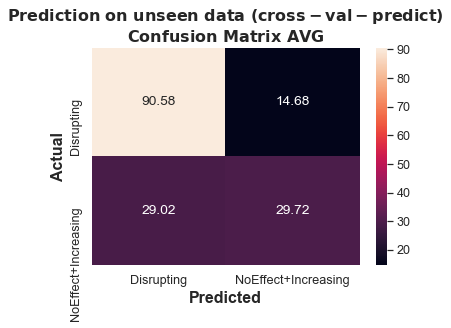

In [197]:
tns = []
fps = []
fns = []
tps = []

for exp in tqdm(range(predator.n_experiment)):
    y_pred_temp = cross_val_predict(
        predator.finalized_models[exp], 
        predator.data_materials["Xs_shap_10"][exp], 
        predator.data_materials["ys"][exp], 
        cv=StratifiedKFold(shuffle=True, n_splits=10)
    )

    tn, fp, fn, tp = confusion_matrix(
        predator.data_materials["ys"][exp], y_pred_temp
    ).ravel()
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)

tn_avg = np.array(tns).mean()
fp_avg = np.array(fps).mean()
fn_avg = np.array(fns).mean()
tp_avg = np.array(tps).mean()

## i am not sure if FP and FN are in correct place. check how reshape function behaves.
conf_matrix_avg = np.array([tn_avg, fp_avg, fn_avg, tp_avg]).reshape(2, 2)  
# print(conf_matrix_avg)

label_names = ["Disrupting", "NoEffect+Increasing"]

sns.heatmap(
    conf_matrix_avg,
    annot=True,
    fmt=".2f",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.title("$\mathbf{Prediction\ on\ unseen\ data\ (cross-val-predict)}$\n$\mathbf{Confusion\ Matrix\ AVG}$", fontsize=16, fontweight="bold")
plt.ylabel("Actual", fontsize=16, fontweight="bold")
plt.xlabel("Predicted", fontsize=16, fontweight="bold")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

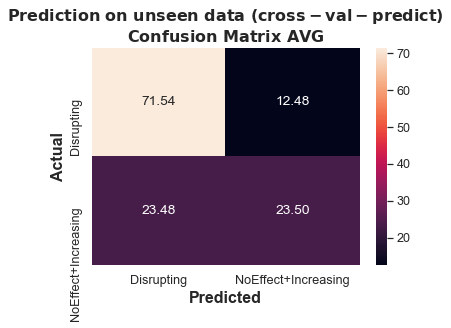

In [199]:
tns = []
fps = []
fns = []
tps = []

for exp in tqdm(range(predator.n_experiment)):
    y_pred_temp = cross_val_predict(
        predator.tuned_models[exp], 
        predator.data_materials["Xs_train_shap_10"][exp], 
        predator.data_materials["ys_train"][exp], 
        cv=StratifiedKFold(shuffle=True, n_splits=10)
    )

    tn, fp, fn, tp = confusion_matrix(
        predator.data_materials["ys_train"][exp], y_pred_temp
    ).ravel()
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)

tn_avg = np.array(tns).mean()
fp_avg = np.array(fps).mean()
fn_avg = np.array(fns).mean()
tp_avg = np.array(tps).mean()

## i am not sure if FP and FN are in correct place. check how reshape function behaves.
conf_matrix_avg = np.array([tn_avg, fp_avg, fn_avg, tp_avg]).reshape(2, 2)  
# print(conf_matrix_avg)

label_names = ["Disrupting", "NoEffect+Increasing"]

sns.heatmap(
    conf_matrix_avg,
    annot=True,
    fmt=".2f",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.title("$\mathbf{Prediction\ on\ unseen\ data\ (cross-val-predict)}$\n$\mathbf{Confusion\ Matrix\ AVG}$", fontsize=16, fontweight="bold")
plt.ylabel("Actual", fontsize=16, fontweight="bold")
plt.xlabel("Predicted", fontsize=16, fontweight="bold")
plt.show()

In [155]:
tn, fp, fn, tp

(87, 15, 17, 45)

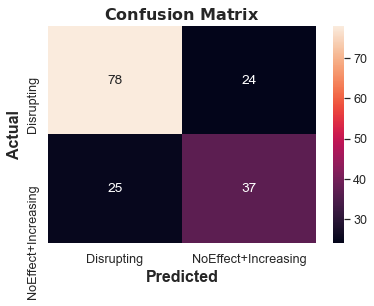

                     precision    recall  f1-score   support

         Disrupting       0.76      0.76      0.76       102
NoEffect+Increasing       0.61      0.60      0.60        62

           accuracy                           0.70       164
          macro avg       0.68      0.68      0.68       164
       weighted avg       0.70      0.70      0.70       164



In [196]:
exp = 0
cross_val_confusion_matrix_via(
    model_param=predator.finalized_models[exp],
    X_train_param=predator.data_materials["Xs_shap_10"][exp],
    y_train_param=predator.data_materials["ys"][exp],
    print_report=True,
)

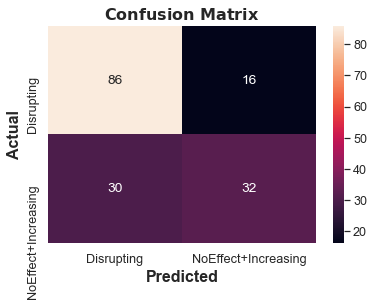

                     precision    recall  f1-score   support

         Disrupting       0.74      0.84      0.79       102
NoEffect+Increasing       0.67      0.52      0.58        62

           accuracy                           0.72       164
          macro avg       0.70      0.68      0.69       164
       weighted avg       0.71      0.72      0.71       164



In [139]:
cross_val_confusion_matrix_via(
    model_param=predator.default_models[0],
    X_train_param=predator.data_materials["Xs"][0],
    y_train_param=predator.data_materials["ys"][0],
    print_report=True,
)

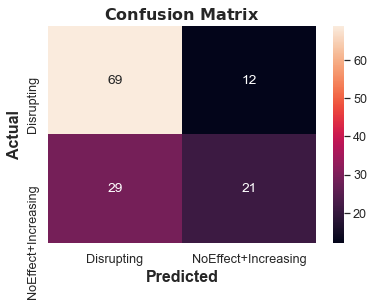

                     precision    recall  f1-score   support

         Disrupting       0.70      0.85      0.77        81
NoEffect+Increasing       0.64      0.42      0.51        50

           accuracy                           0.69       131
          macro avg       0.67      0.64      0.64       131
       weighted avg       0.68      0.69      0.67       131



In [140]:
cross_val_confusion_matrix_via(
    model_param=predator.default_models[0],
    X_train_param=predator.data_materials["Xs_train"][0],
    y_train_param=predator.data_materials["ys_train"][0],
    print_report=True,
)

In [118]:
pred_finalized_test = predator.finalized_models[0].predict(
    predator.data_materials["Xs_shap_10"][0]
)

In [125]:
# train
pred_tuned_test = predator.tuned_models[0].predict(
    predator.data_materials["Xs_train_shap_10"][0]
)

In [128]:
# train
pred_default_test = predator.default_models[0].predict(
    predator.data_materials["Xs_train"][0]
)

In [129]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [130]:
accuracy_score(predator.data_materials["ys"][0], pred_finalized_test)

0.8048780487804879

In [131]:
accuracy_score(predator.data_materials["ys_train"][0], pred_tuned_test)

0.7938931297709924

In [133]:
accuracy_score(predator.data_materials["ys_train"][0], pred_default_test)

1.0

In [123]:
del pred_default_test

## Fine Tuning

In [77]:
predator.models[0].classes_

array([0, 1], dtype=int64)

In [73]:
hasattr(predator.models[0], "classes_")

True

# ====

In [35]:
# final_models = []
# for search_obj in randomized_search_objects:
#     final_models.append(search_obj.best_estimator_)

In [36]:
## Prediction on Cancer data.

In [37]:
predator.data_materials.initialize_target_data_materials(
    determined_features, predator.paths.tcga_code_path_pairs
)

2021-09-01 17:06:00 | DEBUG    | helpers.data_materials | Initializing target data materials ..
2021-09-01 17:06:00 | DEBUG    | helpers.data_materials | Initializing brca data materials  ..


In [41]:
predator.predict()

[('brca', '../data/BRCA_INTERFACE_A2.txt')]